Estudo do artigo https://towardsdatascience.com/developing-scorecards-in-python-using-optbinning-ab9a205e1f69.

**Importando as bibliotecas**

In [ ]:
!pip install optbinning

In [ ]:
import pandas                   as pd
import pickle

from optbinning                 import Scorecard, BinningProcess
from sklearn.model_selection    import train_test_split
from sklearn.linear_model       import LogisticRegression
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

In [ ]:
df_application = pd.read_csv("/content/drive/MyDrive/Cursos/OptBinning/application_train.csv", low_memory=True)
df_application.set_index("SK_ID_CURR", inplace=True)

In [ ]:
df_application.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Dividindo em dados de treino e teste
df_application_train, df_application_test, y_train, y_test = train_test_split (df_application, df_application.TARGET, test_size=0.2, random_state=42)

**Features engineering**

In [ ]:
list_features = df_application_train.drop(columns=["TARGET"]).columns.values

In [ ]:
list_categorical = df_application_train.select_dtypes(include=['object', 'category']).columns.values

In [ ]:
#Definindo os critérios a serem usados para definir os bins ideais
#This constraint can be a specific number of bins or a minimum number of samples per bin
selection_criteria = {"iv": {"min": 0.005, 'max':0.5, "strategy": "highest"}}

In [ ]:
#Instanciando BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
)

**Escolhendo o estimador linear**

C: float, default=1.0
<br>Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

In [ ]:
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

**Criando o ScoreCard**

The class ScoreCard offers the possibility of combining the binned dataset generated from a BinningProcess with a linear estimator from Scikit-Learn to generate a production-ready Scorecard

In [ ]:
#Definindo o método de normalização e os valores
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 1000}

In [ ]:
#Instanciando o ScoreCard
scorecard = Scorecard(
    target='TARGET',
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True,
)

In [ ]:
#Ajustando o ScoreCard
scorecard.fit(df_application_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATI...
          estimator=LogisticRegression(C=3, class_weight=None, dual=False,
                                       fit_intercept=True, intercept_scaling=1,
                                       l1_ratio=None, max_iter=1000,
                                       multi_class='auto', n_jobs=None,
                                       penalty='l2', random_state=161,
                                       solver='lbfgs', tol=0.0001, verbose=0,
                                       warm_start=False),
          intercept_

**Visualizando e validando o ScoreCard**

In [ ]:
scorecard_summary = scorecard.table(style="detailed").round(3)

In [ ]:
scorecard_summary

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,NAME_CONTRACT_TYPE,0,[Revolving loans],23518,0.096,22243,1275,0.054,0.427,0.015,0.002,-0.638,-6.574
1,NAME_CONTRACT_TYPE,1,[Cash loans],222490,0.904,203889,18601,0.084,-0.037,0.001,0.000,-0.638,6.799
2,NAME_CONTRACT_TYPE,2,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.638,5.728
3,NAME_CONTRACT_TYPE,3,Missing,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.638,5.728
0,CODE_GENDER,0,"[XNA, F]",161858,0.658,150524,11334,0.070,0.155,0.015,0.002,-0.707,0.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,AMT_REQ_CREDIT_BUREAU_YEAR,2,"[1.50, 3.50)",67066,0.273,61690,5376,0.080,0.009,0.000,0.000,-0.379,5.581
3,AMT_REQ_CREDIT_BUREAU_YEAR,3,"[3.50, 4.50)",16600,0.067,15243,1357,0.082,-0.013,0.000,0.000,-0.379,5.946
4,AMT_REQ_CREDIT_BUREAU_YEAR,4,"[4.50, inf)",21011,0.085,19160,1851,0.088,-0.095,0.001,0.000,-0.379,7.343
5,AMT_REQ_CREDIT_BUREAU_YEAR,5,Special,0,0.000,0,0,0.000,0.000,0.000,0.000,-0.379,5.728


**Visualizando a performance do ScoreCard**

In [ ]:
#Assign score and predicted probability to test dataset
df_application_test.loc[:,"score"] = scorecard.score(df_application_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


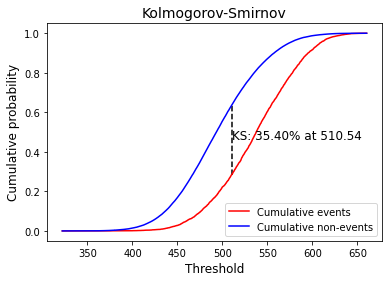

In [ ]:
#Kolmogorov_Smirnov Plot
plot_ks(df_application_test.TARGET, df_application_test.score)

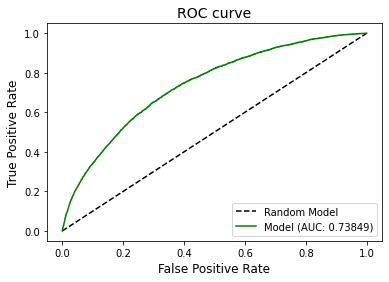

In [ ]:
#ROC-AUC plot
plot_auc_roc(df_application_test.TARGET, df_application_test.score)

**Colocando o ScoreCard em produção**

O módulo pickle implementa um algoritmo para transformar um objeto Python arbitrário em uma série de bytes. Esse processo também é chamado de “serializar” o objeto. O fluxo de bytes que representa o objeto pode ser transmitido ou armazenado e, posteriormente, reconstruído para criar um novo objeto com as mesmas características.
</br> O dump, e load - cada um toma como parâmetro um arquivo aberto (ou outro objeto com a interface de arquivo) - e salva o conteúdo serializado do objeto nesse arquivo (ou o carregam dele, no caso do load).

In [ ]:
#To pickle a Scorecard object
with open('scorecard_model.pickle', 'wb') as pfile:
   pickle.dump(scorecard, pfile)

In [ ]:
#To unpickle it
with open("scorecard_model.pickle", 'rb') as scorecard_pickle:
    scorecard_production = pickle.load(scorecard_pickle)

In [ ]:
#To use the Scorecard model for predictions in production
#For one sample
scorecard_production.score(df_application_test.iloc[0:1, :])

array([563.64236463])

In [ ]:
#For a few samples
scorecard_production.score(df_application_test.iloc[0:3, :])

array([563.64236463, 442.97868964, 533.85479792])